## Visualize images on model without adaption

In order to investigate on which images the model performs good and on which images it performs bad, we visualize the images, GT and predicted density maps. Note that this shows images **WITHOUT ADAPTATION**.


In [2]:
import sys
sys.path.append("../")

In [14]:
data_folder = "data/"
im_folder = "images_384_VarV2"
gt_folder = "gt_density_map_adaptive_384_VarV2"

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [55]:
from model import CountRegressor, Resnet50FPN
from utils import Transform, MAPS, Scales, extract_features
import torch
import json

In [62]:
class PredictNoAdaptation:
    
    def __init__(self, im_dir, pretrained_path, anno_file):
        self.resnet50_conv = Resnet50FPN()
        self.resnet50_conv.eval()

        self.regressor = CountRegressor(6, pool='mean')
        self.regressor.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu')))
        self.regressor.eval()
        
        self.im_dir = im_dir

        with open(anno_file) as f:
            self.annotations = json.load(f)

    def predict(self, im_id):
        anno = self.annotations[im_id]
        bboxes = anno['box_examples_coordinates']
        dots = np.array(anno['points'])

        rects = list()
        for bbox in bboxes:
            x1, y1 = bbox[0][0], bbox[0][1]
            x2, y2 = bbox[2][0], bbox[2][1]
            rects.append([y1, x1, y2, x2])

        image = Image.open('{}/{}'.format(self.im_dir, im_id))
        image.load()
        sample = {'image': image, 'lines_boxes': rects}
        sample = Transform(sample)
        image, boxes = sample['image'], sample['boxes']

        image = image
        boxes = boxes

        with torch.no_grad(): features = extract_features(self.resnet50_conv, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales)
        with torch.no_grad(): output = self.regressor(features)

        return output

In [63]:
predictor = PredictNoAdaptation(os.path.join("../", data_folder, im_folder),
                               os.path.join("../", data_folder, "pretrainedModels", "FamNet_Save1.pth"),
                               os.path.join("../", data_folder, "annotation_FSC147_384.json"))

10 images with smallest relative absolute error on test set without adaptation
```
('4119.jpg', 2.47955322265625e-05), 
('2207.jpg', 0.00012502670288085937), 
('2241.jpg', 0.000411834716796875), 
('5938.jpg', 0.0010505184050529233), 
('309.jpg', 0.0018459083759679203), 
('4881.jpg', 0.00201263427734375), 
('7136.jpg', 0.002112202260686063), 
('5928.jpg', 0.0035333962276064114), 
('6044.jpg', 0.004016343937363736), 
('3336.jpg', 0.0040943357679579)
```
10 images with highest relative absolute error  on test set without adaptation
```
('6869.jpg', 2.84359623835637), 
('6266.jpg', 2.8620304780847885), 
('6245.jpg', 2.8686656951904297), 
('6.jpg', 2.9522103203667536), 
('4421.jpg', 3.070706844329834), 
('4885.jpg', 3.1824111938476562), 
('6842.jpg', 3.7049361334906683), 
('7676.jpg', 4.103789230872845), 
('5365.jpg', 7.4104724460177955), 
('7171.jpg', 48.82430795522836)
```

### Select image here

In [189]:
image_id = "6869"
image_name = f"{image_id}.jpg"
gt_name = f"{image_id}.npy"

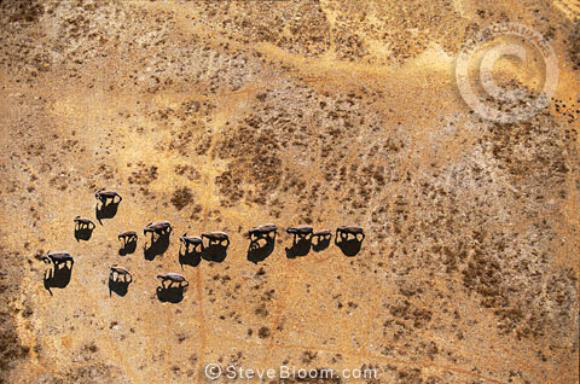

In [190]:
img = Image.open(os.path.join("../", data_folder, im_folder, image_name))
img

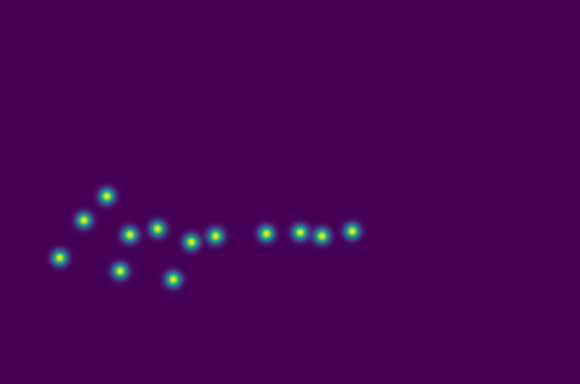

In [191]:
gt_map = np.load(os.path.join("../", data_folder, gt_folder, gt_name))
gt_map_image = Image.fromarray(np.uint8(cm.viridis(gt_map/np.max(gt_map))*255))
gt_map_image.save(f"visualizations/{image_id}_gt.png")
gt_map_image

In [192]:
output = predictor.predict(image_name)
output = output.numpy()[0, 0, :, :]


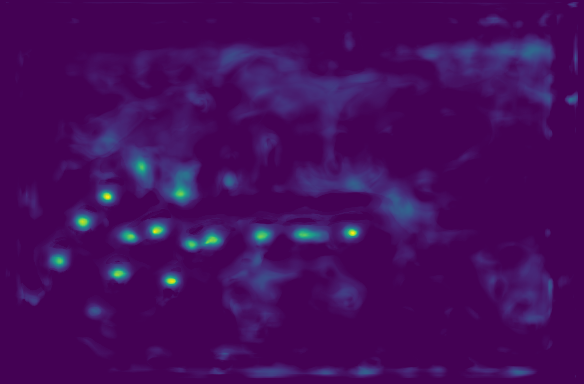

In [193]:
gt_pred_image = Image.fromarray(np.uint8(cm.viridis(output/np.max(output))*255))
gt_pred_image.save(f"visualizations/{image_id}_pred.png")
gt_pred_image

In [194]:
img.resize(gt_map.shape[::-1])
img.save(f"visualizations/{image_id}_img.png")

In [195]:
count_gt, count_pred = np.sum(gt_map), np.sum(output)
print(f"GT: {count_gt}, Pred: {count_pred}, Abs error: {np.abs(count_gt - count_pred)}")

GT: 12.99999713897705, Pred: 49.93274688720703, Abs error: 36.9327507019043
